# Introduction

This notebook is a very basic and simple introductory primer to the method of ensembling (combining) base learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.

The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.

I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:

[Stacking Starter][1] : by Faron 


Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner.  My other standalone Kaggle [script][2] which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve


  [1]: https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
  [2]: https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808

In [30]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

# Feature Exploration, Engineering and Cleaning 

Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [31]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables 

**Feature Engineering**

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work 

[Titanic Best Working Classfier][1] : by Sina


  [1]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [32]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [33]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations 

In [34]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


**Pearson Correlation Heatmap**

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

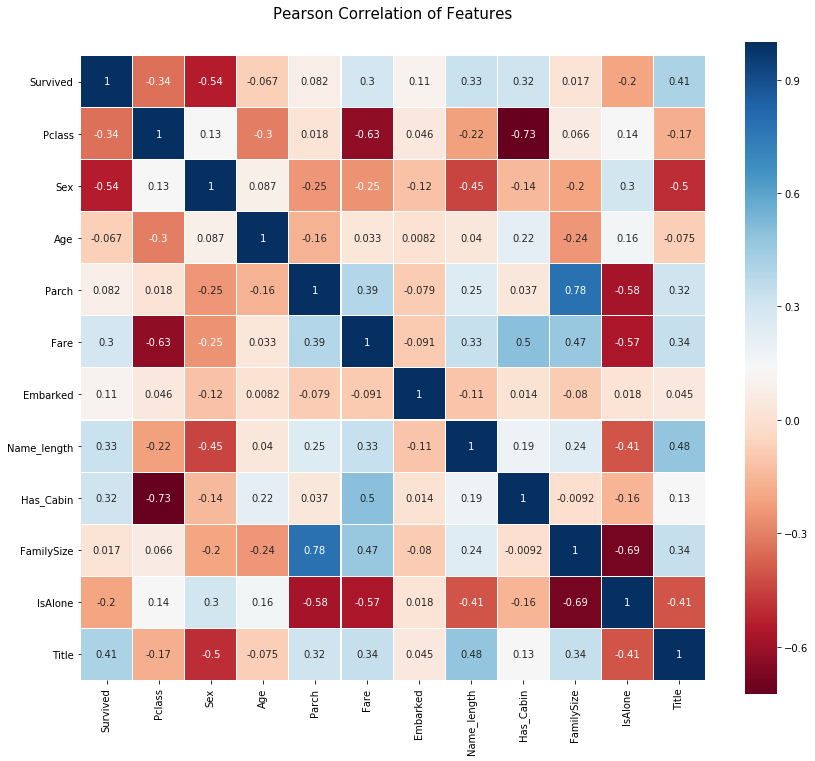

In [35]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

**Takeaway from the Plots**

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

**Pairplots**

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

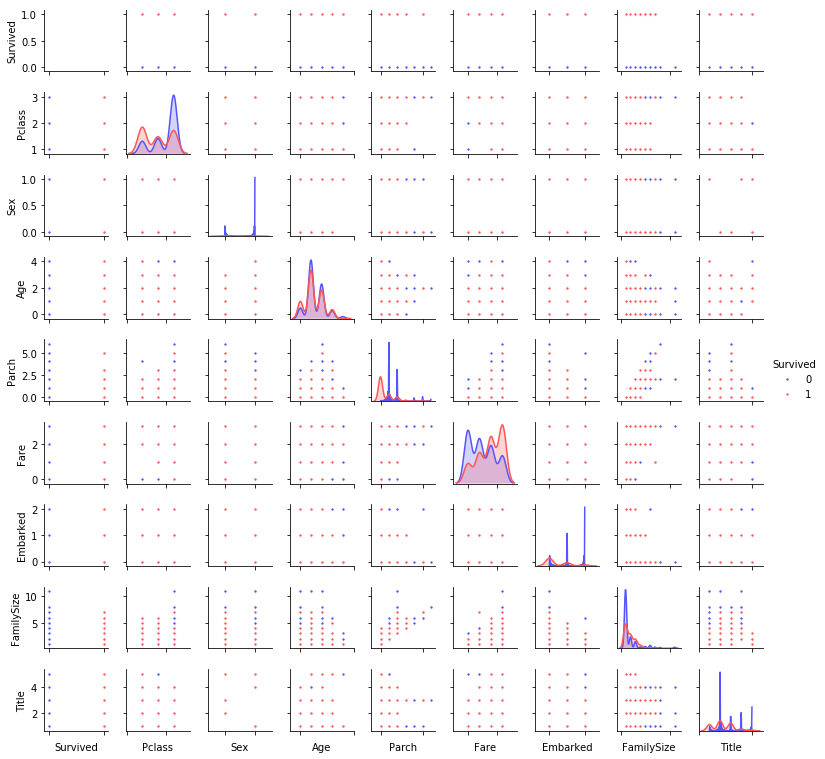

In [36]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

Creating a Stacking ensemble!

### Helpers via Python Classes

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class *SklearnHelper* that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as  won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [37]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.

**def init** : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [38]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models 

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

**Parameters**

Just a quick summary of the parameters that we will be listing here for completeness,

**n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.

**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)

**max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high  a number would run the risk of overfitting as one would be growing the tree too deep

**verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

 Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with. 

In [39]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 575,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 3
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':575,
    #'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'verbose': 3
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 575,
    'learning_rate' : 0.95
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 575,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'verbose': 3
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [40]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**Creating NumPy arrays out of our train and test sets**

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [41]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

**Output of the First level Predictions** 

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [42]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575
building tree 6 of 575
building tree 7 of 575
building tree 8 of 575
building tree 9 of 575
building tree 10 of 575building tree 11 of 575

building tree 12 of 575
building tree 13 of 575building tree 14 of 575

building tree 15 of 575
building tree 16 of 575
building tree 17 of 575building tree 18 of 575

building tree 19 of 575
building tree 20 of 575
building tree 21 of 575
building tree 22 of 575
building tree 23 of 575
building tree 24 of 575
building tree 25 of 575building tree 26 of 575
building tree 27 of 575

building tree 28 of 575
building tree 29 of 575
building tree 30 of 575building tree 31 of 575

building tree 32 of 575
building tree 33 of 575
building tree 34 of 575
building tree 35 of 575
building tree 36 of 575
building tree 37 of 575building tree 38 of 575

building tree 39 of 575
building tree 40 of 575
building tree 41 of 575building tree 42 of 575

b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s




building tree 141 of 575building tree 142 of 575
building tree 143 of 575

building tree 144 of 575
building tree 145 of 575
building tree 146 of 575
building tree 147 of 575
building tree 148 of 575
building tree 149 of 575building tree 150 of 575

building tree 151 of 575
building tree 152 of 575
building tree 153 of 575
building tree 154 of 575
building tree 155 of 575
building tree 156 of 575
building tree 157 of 575
building tree 158 of 575
building tree 159 of 575
building tree 160 of 575
building tree 161 of 575
building tree 162 of 575
building tree 163 of 575
building tree 164 of 575
building tree 165 of 575
building tree 166 of 575
building tree 167 of 575
building tree 168 of 575building tree 169 of 575

building tree 170 of 575
building tree 171 of 575
building tree 172 of 575
building tree 173 of 575
building tree 174 of 575
building tree 175 of 575
building tree 176 of 575
building tree 177 of 575
building tree 178 of 575
building tree 179 of 575
building tree 180 of 57

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.3s



building tree 385 of 575
building tree 386 of 575
building tree 387 of 575building tree 388 of 575

building tree 389 of 575
building tree 390 of 575building tree 391 of 575

building tree 392 of 575building tree 393 of 575

building tree 394 of 575building tree 395 of 575

building tree 396 of 575
building tree 397 of 575
building tree 398 of 575
building tree 399 of 575
building tree 400 of 575
building tree 401 of 575
building tree 402 of 575
building tree 403 of 575building tree 404 of 575

building tree 405 of 575
building tree 406 of 575
building tree 407 of 575
building tree 408 of 575
building tree 409 of 575
building tree 410 of 575
building tree 411 of 575
building tree 412 of 575
building tree 413 of 575
building tree 414 of 575
building tree 415 of 575building tree 416 of 575

building tree 417 of 575
building tree 418 of 575
building tree 419 of 575building tree 420 of 575

building tree 421 of 575
building tree 422 of 575
building tree 423 of 575building tree 424 of 575


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished


building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575building tree 6 of 575
building tree 7 of 575

building tree 8 of 575
building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575
building tree 14 of 575
building tree 15 of 575
building tree 16 of 575
building tree 17 of 575building tree 18 of 575
building tree 19 of 575

building tree 20 of 575
building tree 21 of 575
building tree 22 of 575
building tree 23 of 575
building tree 24 of 575
building tree 25 of 575building tree 26 of 575

building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575
building tree 31 of 575
building tree 32 of 575
building tree 33 of 575
building tree 34 of 575
building tree 35 of 575
building tree 36 of 575
building tree 37 of 575
building tree 38 of 575
building tree 39 of 575
building tree 40 of 575
building tree 41 of 575
building tree 42 of 575
b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s


building tree 112 of 575
building tree 113 of 575
building tree 114 of 575
building tree 115 of 575
building tree 116 of 575
building tree 117 of 575building tree 118 of 575

building tree 119 of 575
building tree 120 of 575
building tree 121 of 575
building tree 122 of 575
building tree 123 of 575
building tree 124 of 575
building tree 125 of 575
building tree 126 of 575
building tree 127 of 575building tree 128 of 575

building tree 129 of 575building tree 130 of 575

building tree 131 of 575
building tree 132 of 575
building tree 133 of 575building tree 134 of 575

building tree 135 of 575
building tree 136 of 575
building tree 137 of 575
building tree 138 of 575
building tree 139 of 575
building tree 140 of 575building tree 141 of 575

building tree 142 of 575
building tree 143 of 575building tree 144 of 575building tree 145 of 575


building tree 146 of 575
building tree 147 of 575
building tree 148 of 575
building tree 149 of 575
building tree 150 of 575
building tree 151 of 575


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.4s


building tree 321 of 575
building tree 322 of 575
building tree 323 of 575
building tree 324 of 575building tree 325 of 575

building tree 326 of 575
building tree 327 of 575
building tree 328 of 575building tree 329 of 575

building tree 330 of 575building tree 331 of 575

building tree 332 of 575
building tree 333 of 575
building tree 334 of 575
building tree 335 of 575
building tree 336 of 575
building tree 337 of 575
building tree 338 of 575
building tree 339 of 575
building tree 340 of 575
building tree 341 of 575building tree 342 of 575

building tree 343 of 575
building tree 344 of 575
building tree 345 of 575
building tree 346 of 575
building tree 347 of 575
building tree 348 of 575building tree 349 of 575

building tree 350 of 575
building tree 351 of 575
building tree 352 of 575building tree 353 of 575

building tree 354 of 575
building tree 355 of 575
building tree 356 of 575building tree 357 of 575

building tree 358 of 575
building tree 359 of 575building tree 360 of 575



[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s



building tree 561 of 575
building tree 562 of 575building tree 563 of 575

building tree 564 of 575
building tree 565 of 575
building tree 566 of 575
building tree 567 of 575
building tree 568 of 575
building tree 569 of 575
building tree 570 of 575
building tree 571 of 575
building tree 572 of 575
building tree 573 of 575
building tree 574 of 575
building tree 575 of 575


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished


building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575
building tree 6 of 575
building tree 7 of 575building tree 8 of 575

building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575
building tree 14 of 575
building tree 15 of 575
building tree 16 of 575building tree 17 of 575

building tree 18 of 575
building tree 19 of 575
building tree 20 of 575
building tree 21 of 575
building tree 22 of 575
building tree 23 of 575
building tree 24 of 575
building tree 25 of 575
building tree 26 of 575
building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575
building tree 31 of 575
building tree 32 of 575
building tree 33 of 575building tree 34 of 575

building tree 35 of 575
building tree 36 of 575
building tree 37 of 575building tree 38 of 575

building tree 39 of 575
building tree 40 of 575
building tree 41 of 575building tree 42 of 575

b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s


building tree 128 of 575

building tree 129 of 575
building tree 130 of 575
building tree 131 of 575
building tree 132 of 575building tree 133 of 575

building tree 134 of 575
building tree 135 of 575building tree 136 of 575

building tree 137 of 575
building tree 138 of 575
building tree 139 of 575
building tree 140 of 575
building tree 141 of 575
building tree 142 of 575
building tree 143 of 575
building tree 144 of 575building tree 145 of 575

building tree 146 of 575
building tree 147 of 575
building tree 148 of 575
building tree 149 of 575
building tree 150 of 575
building tree 151 of 575building tree 152 of 575

building tree 153 of 575
building tree 154 of 575
building tree 155 of 575
building tree 156 of 575building tree 157 of 575
building tree 158 of 575

building tree 159 of 575
building tree 160 of 575
building tree 161 of 575
building tree 162 of 575building tree 163 of 575

building tree 164 of 575
building tree 165 of 575building tree 166 of 575

building tree 167 of 575

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.3s


building tree 392 of 575
building tree 393 of 575
building tree 394 of 575
building tree 395 of 575
building tree 396 of 575building tree 397 of 575

building tree 398 of 575
building tree 399 of 575
building tree 400 of 575
building tree 401 of 575
building tree 402 of 575
building tree 403 of 575
building tree 404 of 575
building tree 405 of 575
building tree 406 of 575
building tree 407 of 575building tree 408 of 575

building tree 409 of 575
building tree 410 of 575
building tree 411 of 575
building tree 412 of 575
building tree 413 of 575
building tree 414 of 575
building tree 415 of 575building tree 416 of 575

building tree 417 of 575
building tree 418 of 575
building tree 419 of 575
building tree 420 of 575building tree 421 of 575

building tree 422 of 575
building tree 423 of 575
building tree 424 of 575
building tree 425 of 575
building tree 426 of 575building tree 427 of 575

building tree 428 of 575
building tree 429 of 575
building tree 430 of 575building tree 431 of 575



[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.0s finished


building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575
building tree 6 of 575building tree 7 of 575

building tree 8 of 575
building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575
building tree 14 of 575
building tree 15 of 575
building tree 16 of 575
building tree 17 of 575building tree 18 of 575

building tree 19 of 575
building tree 20 of 575
building tree 21 of 575
building tree 22 of 575building tree 23 of 575

building tree 24 of 575building tree 25 of 575

building tree 26 of 575
building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575
building tree 31 of 575
building tree 32 of 575
building tree 33 of 575
building tree 34 of 575
building tree 35 of 575
building tree 36 of 575
building tree 37 of 575building tree 38 of 575building tree 39 of 575


building tree 40 of 575
building tree 41 of 575building tree 42 of 575

b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s


building tree 128 of 575
building tree 129 of 575
building tree 130 of 575
building tree 131 of 575
building tree 132 of 575building tree 133 of 575

building tree 134 of 575
building tree 135 of 575
building tree 136 of 575building tree 137 of 575

building tree 138 of 575building tree 139 of 575building tree 140 of 575


building tree 141 of 575
building tree 142 of 575
building tree 143 of 575
building tree 144 of 575
building tree 145 of 575
building tree 146 of 575
building tree 147 of 575
building tree 148 of 575
building tree 149 of 575
building tree 150 of 575
building tree 151 of 575
building tree 152 of 575
building tree 153 of 575
building tree 154 of 575
building tree 155 of 575
building tree 156 of 575
building tree 157 of 575
building tree 158 of 575
building tree 159 of 575
building tree 160 of 575
building tree 161 of 575
building tree 162 of 575
building tree 163 of 575building tree 164 of 575
building tree 165 of 575building tree 166 of 575
building tree 167 of 575




[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.3s


building tree 374 of 575
building tree 375 of 575
building tree 376 of 575
building tree 377 of 575
building tree 378 of 575
building tree 379 of 575
building tree 380 of 575
building tree 381 of 575
building tree 382 of 575
building tree 383 of 575
building tree 384 of 575
building tree 385 of 575
building tree 386 of 575
building tree 387 of 575
building tree 388 of 575building tree 389 of 575

building tree 390 of 575
building tree 391 of 575
building tree 392 of 575
building tree 393 of 575
building tree 394 of 575
building tree 395 of 575
building tree 396 of 575
building tree 397 of 575
building tree 398 of 575
building tree 399 of 575building tree 400 of 575

building tree 401 of 575
building tree 402 of 575
building tree 403 of 575
building tree 404 of 575
building tree 405 of 575
building tree 406 of 575
building tree 407 of 575
building tree 408 of 575
building tree 409 of 575building tree 410 of 575

building tree 411 of 575
building tree 412 of 575
building tree 413 of 575


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished


building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575building tree 6 of 575

building tree 7 of 575
building tree 8 of 575
building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575
building tree 14 of 575
building tree 15 of 575
building tree 16 of 575
building tree 17 of 575
building tree 18 of 575
building tree 19 of 575
building tree 20 of 575building tree 21 of 575

building tree 22 of 575
building tree 23 of 575
building tree 24 of 575
building tree 25 of 575
building tree 26 of 575
building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575
building tree 31 of 575
building tree 32 of 575
building tree 33 of 575building tree 34 of 575

building tree 35 of 575building tree 36 of 575

building tree 37 of 575
building tree 38 of 575
building tree 39 of 575
building tree 40 of 575
building tree 41 of 575
building tree 42 of 575
b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s


building tree 135 of 575
building tree 136 of 575
building tree 137 of 575building tree 138 of 575

building tree 139 of 575building tree 140 of 575

building tree 141 of 575
building tree 142 of 575
building tree 143 of 575
building tree 144 of 575
building tree 145 of 575building tree 146 of 575

building tree 147 of 575building tree 148 of 575

building tree 149 of 575
building tree 150 of 575
building tree 151 of 575
building tree 152 of 575
building tree 153 of 575
building tree 154 of 575building tree 155 of 575

building tree 156 of 575
building tree 157 of 575
building tree 158 of 575
building tree 159 of 575
building tree 160 of 575
building tree 161 of 575building tree 162 of 575

building tree 163 of 575
building tree 164 of 575
building tree 165 of 575
building tree 166 of 575
building tree 167 of 575
building tree 168 of 575
building tree 169 of 575building tree 170 of 575

building tree 171 of 575
building tree 172 of 575
building tree 173 of 575
building tree 174 of 575


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.3s


building tree 376 of 575
building tree 377 of 575
building tree 378 of 575
building tree 379 of 575
building tree 380 of 575
building tree 381 of 575
building tree 382 of 575
building tree 383 of 575building tree 384 of 575

building tree 385 of 575
building tree 386 of 575
building tree 387 of 575
building tree 388 of 575
building tree 389 of 575
building tree 390 of 575
building tree 391 of 575
building tree 392 of 575
building tree 393 of 575
building tree 394 of 575
building tree 395 of 575
building tree 396 of 575building tree 397 of 575

building tree 398 of 575
building tree 399 of 575
building tree 400 of 575
building tree 401 of 575building tree 402 of 575

building tree 403 of 575
building tree 404 of 575building tree 405 of 575

building tree 406 of 575
building tree 407 of 575
building tree 408 of 575
building tree 409 of 575building tree 410 of 575

building tree 411 of 575
building tree 412 of 575building tree 413 of 575

building tree 414 of 575
building tree 415 of 575b

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.2s finished


building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575
building tree 6 of 575
building tree 7 of 575
building tree 8 of 575
building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575building tree 14 of 575

building tree 15 of 575
building tree 16 of 575
building tree 17 of 575
building tree 18 of 575building tree 19 of 575building tree 20 of 575


building tree 21 of 575building tree 22 of 575

building tree 23 of 575
building tree 24 of 575
building tree 25 of 575
building tree 26 of 575
building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575building tree 31 of 575

building tree 32 of 575
building tree 33 of 575
building tree 34 of 575
building tree 35 of 575
building tree 36 of 575
building tree 37 of 575building tree 38 of 575

building tree 39 of 575
building tree 40 of 575
building tree 41 of 575building tree 42 of 575

b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s


building tree 120 of 575
building tree 121 of 575
building tree 122 of 575
building tree 123 of 575
building tree 124 of 575
building tree 125 of 575
building tree 126 of 575
building tree 127 of 575
building tree 128 of 575
building tree 129 of 575
building tree 130 of 575building tree 131 of 575building tree 132 of 575


building tree 133 of 575
building tree 134 of 575
building tree 135 of 575
building tree 136 of 575
building tree 137 of 575building tree 138 of 575
building tree 139 of 575

building tree 140 of 575building tree 141 of 575

building tree 142 of 575
building tree 143 of 575
building tree 144 of 575
building tree 145 of 575
building tree 146 of 575building tree 147 of 575

building tree 148 of 575
building tree 149 of 575
building tree 150 of 575
building tree 151 of 575
building tree 152 of 575building tree 153 of 575

building tree 154 of 575
building tree 155 of 575
building tree 156 of 575
building tree 157 of 575
building tree 158 of 575
building tree 159 of 575


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.4s


building tree 318 of 575building tree 319 of 575
building tree 320 of 575

building tree 321 of 575
building tree 322 of 575
building tree 323 of 575
building tree 324 of 575
building tree 325 of 575
building tree 326 of 575
building tree 327 of 575
building tree 328 of 575
building tree 329 of 575
building tree 330 of 575building tree 331 of 575

building tree 332 of 575
building tree 333 of 575
building tree 334 of 575
building tree 335 of 575
building tree 336 of 575
building tree 337 of 575
building tree 338 of 575
building tree 339 of 575
building tree 340 of 575
building tree 341 of 575
building tree 342 of 575building tree 343 of 575

building tree 344 of 575
building tree 345 of 575
building tree 346 of 575
building tree 347 of 575
building tree 348 of 575
building tree 349 of 575
building tree 350 of 575
building tree 351 of 575
building tree 352 of 575
building tree 353 of 575building tree 354 of 575

building tree 355 of 575building tree 356 of 575

building tree 357 of 575b

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.9s finished


building tree 527 of 575
building tree 528 of 575
building tree 529 of 575
building tree 530 of 575
building tree 531 of 575
building tree 532 of 575
building tree 533 of 575
building tree 534 of 575
building tree 535 of 575
building tree 536 of 575
building tree 537 of 575
building tree 538 of 575
building tree 539 of 575
building tree 540 of 575
building tree 541 of 575
building tree 542 of 575
building tree 543 of 575building tree 544 of 575

building tree 545 of 575
building tree 546 of 575
building tree 547 of 575
building tree 548 of 575building tree 549 of 575building tree 550 of 575


building tree 551 of 575
building tree 552 of 575building tree 553 of 575

building tree 554 of 575
building tree 555 of 575
building tree 556 of 575building tree 557 of 575

building tree 558 of 575
building tree 559 of 575
building tree 560 of 575
building tree 561 of 575
building tree 562 of 575
building tree 563 of 575
building tree 564 of 575
building tree 565 of 575
building tree 566 of 575


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 575 out of 575 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.

      Iter       Train Loss   Remaining Time 
         1           1.2373            1.14s
         2           1.1489            1.43s
         3           1.0772            1.53s
         4           1.0164            1.43s
         5           0.9627            1.37s
         6           0.9181            1.43s
         7           0.8815            1.38s
         8           0.8500            1.35s
         9           0.8201            1.38s
        10           0.7945            1.41s
        11           0.7716            1.39s
        12           0.7526            1.41s
        13           0.7358            1.38s
        14           0.7181            1.36s
        15           0.7034            1.34s
        16           0.6905            1.36s
        17           0.6772            1.35s
        18           0.6652            1.36s
        19           0.6546            1.38s
        20           0.6430            1.36s
        21           0.6338            1.35s
        2

       256           0.1951            0.70s
       257           0.1937            0.70s
       258           0.1933            0.70s
       259           0.1931            0.70s
       260           0.1927            0.69s
       261           0.1926            0.69s
       262           0.1924            0.69s
       263           0.1919            0.69s
       264           0.1915            0.68s
       265           0.1904            0.68s
       266           0.1899            0.68s
       267           0.1892            0.68s
       268           0.1887            0.68s
       269           0.1881            0.67s
       270           0.1875            0.67s
       271           0.1872            0.67s
       272           0.1872            0.67s
       273           0.1870            0.66s
       274           0.1864            0.66s
       275           0.1861            0.66s
       276           0.1857            0.66s
       277           0.1847            0.66s
       278

       512           0.1228            0.14s
       513           0.1225            0.14s
       514           0.1224            0.13s
       515           0.1221            0.13s
       516           0.1220            0.13s
       517           0.1219            0.13s
       518           0.1218            0.13s
       519           0.1218            0.12s
       520           0.1216            0.12s
       521           0.1216            0.12s
       522           0.1215            0.12s
       523           0.1214            0.12s
       524           0.1214            0.11s
       525           0.1213            0.11s
       526           0.1212            0.11s
       527           0.1212            0.11s
       528           0.1210            0.10s
       529           0.1210            0.10s
       530           0.1209            0.10s
       531           0.1208            0.10s
       532           0.1207            0.10s
       533           0.1207            0.09s
       534

       170           0.2666            0.95s
       171           0.2663            0.94s
       172           0.2659            0.94s
       173           0.2644            0.94s
       174           0.2630            0.94s
       175           0.2621            0.94s
       176           0.2615            0.94s
       177           0.2610            0.94s
       178           0.2586            0.94s
       179           0.2572            0.94s
       180           0.2551            0.94s
       181           0.2539            0.94s
       182           0.2524            0.94s
       183           0.2512            0.94s
       184           0.2501            0.93s
       185           0.2490            0.93s
       186           0.2483            0.93s
       187           0.2470            0.93s
       188           0.2462            0.93s
       189           0.2457            0.92s
       190           0.2453            0.92s
       191           0.2447            0.92s
       192

       427           0.1426            0.33s
       428           0.1425            0.33s
       429           0.1423            0.33s
       430           0.1421            0.33s
       431           0.1420            0.33s
       432           0.1419            0.32s
       433           0.1418            0.32s
       434           0.1413            0.32s
       435           0.1412            0.32s
       436           0.1410            0.32s
       437           0.1408            0.31s
       438           0.1407            0.31s
       439           0.1404            0.31s
       440           0.1403            0.31s
       441           0.1401            0.31s
       442           0.1400            0.31s
       443           0.1398            0.30s
       444           0.1397            0.30s
       445           0.1396            0.30s
       446           0.1395            0.30s
       447           0.1394            0.29s
       448           0.1392            0.29s
       449

        57           0.4419            1.61s
        58           0.4399            1.60s
        59           0.4371            1.60s
        60           0.4326            1.61s
        61           0.4286            1.61s
        62           0.4267            1.60s
        63           0.4224            1.58s
        64           0.4207            1.59s
        65           0.4166            1.58s
        66           0.4133            1.57s
        67           0.4095            1.58s
        68           0.4069            1.58s
        69           0.4054            1.58s
        70           0.4034            1.58s
        71           0.4022            1.58s
        72           0.4010            1.57s
        73           0.3983            1.57s
        74           0.3961            1.57s
        75           0.3935            1.57s
        76           0.3889            1.56s
        77           0.3874            1.56s
        78           0.3826            1.55s
        79

       311           0.1602            0.62s
       312           0.1597            0.63s
       313           0.1592            0.62s
       314           0.1585            0.62s
       315           0.1579            0.62s
       316           0.1577            0.62s
       317           0.1573            0.62s
       318           0.1568            0.62s
       319           0.1565            0.61s
       320           0.1560            0.61s
       321           0.1558            0.61s
       322           0.1554            0.61s
       323           0.1553            0.61s
       324           0.1550            0.61s
       325           0.1547            0.60s
       326           0.1546            0.60s
       327           0.1544            0.60s
       328           0.1541            0.60s
       329           0.1532            0.60s
       330           0.1529            0.59s
       331           0.1525            0.59s
       332           0.1522            0.59s
       333

       543           0.1100            0.08s
       544           0.1099            0.07s
       545           0.1098            0.07s
       546           0.1095            0.07s
       547           0.1094            0.07s
       548           0.1094            0.06s
       549           0.1093            0.06s
       550           0.1091            0.06s
       551           0.1089            0.06s
       552           0.1087            0.06s
       553           0.1086            0.05s
       554           0.1085            0.05s
       555           0.1084            0.05s
       556           0.1083            0.05s
       557           0.1082            0.04s
       558           0.1081            0.04s
       559           0.1081            0.04s
       560           0.1080            0.04s
       561           0.1080            0.03s
       562           0.1079            0.03s
       563           0.1079            0.03s
       564           0.1079            0.03s
       565

       210           0.2551            0.81s
       211           0.2544            0.81s
       212           0.2534            0.81s
       213           0.2529            0.81s
       214           0.2515            0.80s
       215           0.2502            0.80s
       216           0.2493            0.80s
       217           0.2487            0.80s
       218           0.2476            0.80s
       219           0.2471            0.79s
       220           0.2460            0.79s
       221           0.2454            0.79s
       222           0.2445            0.79s
       223           0.2427            0.79s
       224           0.2419            0.78s
       225           0.2411            0.78s
       226           0.2406            0.78s
       227           0.2399            0.78s
       228           0.2394            0.77s
       229           0.2390            0.77s
       230           0.2379            0.77s
       231           0.2370            0.77s
       232

       469           0.1426            0.23s
       470           0.1423            0.23s
       471           0.1422            0.23s
       472           0.1420            0.23s
       473           0.1418            0.22s
       474           0.1417            0.22s
       475           0.1416            0.22s
       476           0.1415            0.22s
       477           0.1414            0.22s
       478           0.1414            0.21s
       479           0.1412            0.21s
       480           0.1412            0.21s
       481           0.1411            0.21s
       482           0.1411            0.20s
       483           0.1410            0.20s
       484           0.1408            0.20s
       485           0.1408            0.20s
       486           0.1407            0.20s
       487           0.1407            0.19s
       488           0.1405            0.19s
       489           0.1403            0.19s
       490           0.1402            0.19s
       491

       148           0.3360            0.89s
       149           0.3349            0.88s
       150           0.3325            0.88s
       151           0.3312            0.88s
       152           0.3305            0.88s
       153           0.3288            0.88s
       154           0.3267            0.88s
       155           0.3245            0.88s
       156           0.3229            0.88s
       157           0.3224            0.87s
       158           0.3204            0.87s
       159           0.3201            0.87s
       160           0.3192            0.87s
       161           0.3189            0.86s
       162           0.3176            0.86s
       163           0.3158            0.86s
       164           0.3154            0.86s
       165           0.3152            0.86s
       166           0.3150            0.85s
       167           0.3123            0.86s
       168           0.3119            0.85s
       169           0.3108            0.85s
       170

       390           0.1704            0.41s
       391           0.1703            0.41s
       392           0.1702            0.41s
       393           0.1700            0.41s
       394           0.1699            0.40s
       395           0.1697            0.40s
       396           0.1695            0.40s
       397           0.1692            0.40s
       398           0.1689            0.40s
       399           0.1687            0.39s
       400           0.1684            0.39s
       401           0.1681            0.39s
       402           0.1677            0.39s
       403           0.1672            0.39s
       404           0.1671            0.39s
       405           0.1668            0.38s
       406           0.1665            0.38s
       407           0.1665            0.38s
       408           0.1664            0.38s
       409           0.1659            0.37s
       410           0.1656            0.37s
       411           0.1654            0.37s
       412

**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [43]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.12753907  0.21709437  0.02567862  0.01778724  0.0687579   0.02113401
  0.09425857  0.06830066  0.06165347  0.01243401  0.28536207]
building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575
building tree 6 of 575building tree 7 of 575

building tree 8 of 575
building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575
building tree 14 of 575building tree 15 of 575

building tree 16 of 575
building tree 17 of 575building tree 18 of 575

building tree 19 of 575building tree 20 of 575

building tree 21 of 575
building tree 22 of 575building tree 23 of 575

building tree 24 of 575
building tree 25 of 575
building tree 26 of 575
building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575
building tree 31 of 575
building tree 32 of 575
building tree 33 of 575
building tree 34 of 575building tree 35 of 575

building tree 36 of 575
building t

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.1s


building tree 130 of 575
building tree 131 of 575
building tree 132 of 575
building tree 133 of 575
building tree 134 of 575building tree 135 of 575

building tree 136 of 575
building tree 137 of 575
building tree 138 of 575
building tree 139 of 575
building tree 140 of 575
building tree 141 of 575
building tree 142 of 575
building tree 143 of 575building tree 144 of 575

building tree 145 of 575
building tree 146 of 575
building tree 147 of 575
building tree 148 of 575
building tree 149 of 575
building tree 150 of 575
building tree 151 of 575building tree 152 of 575

building tree 153 of 575
building tree 154 of 575
building tree 155 of 575
building tree 156 of 575
building tree 157 of 575
building tree 158 of 575
building tree 159 of 575
building tree 160 of 575building tree 161 of 575

building tree 162 of 575
building tree 163 of 575
building tree 164 of 575
building tree 165 of 575
building tree 166 of 575building tree 167 of 575building tree 168 of 575

building tree 169 of 575



[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.3s


building tree 371 of 575building tree 372 of 575

building tree 373 of 575
building tree 374 of 575
building tree 375 of 575
building tree 376 of 575
building tree 377 of 575
building tree 378 of 575
building tree 379 of 575building tree 380 of 575building tree 381 of 575


building tree 382 of 575
building tree 383 of 575
building tree 384 of 575
building tree 385 of 575building tree 386 of 575
building tree 387 of 575

building tree 388 of 575
building tree 389 of 575
building tree 390 of 575
building tree 391 of 575
building tree 392 of 575
building tree 393 of 575
building tree 394 of 575
building tree 395 of 575
building tree 396 of 575
building tree 397 of 575
building tree 398 of 575building tree 399 of 575

building tree 400 of 575
building tree 401 of 575
building tree 402 of 575
building tree 403 of 575
building tree 404 of 575
building tree 405 of 575
building tree 406 of 575
building tree 407 of 575
building tree 408 of 575
building tree 409 of 575
building tree 410 of 575


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:    0.8s finished


[ 0.11390024  0.43949883  0.01367704  0.01095536  0.04321473  0.01884957
  0.02936477  0.09813545  0.02849652  0.02177883  0.18212867]
[ 0.02608696  0.00869565  0.01043478  0.05043478  0.03304348  0.00695652
  0.76695652  0.01391304  0.03478261  0.00347826  0.04521739]
      Iter       Train Loss   Remaining Time 
         1           1.2300            1.15s
         2           1.1485            1.15s
         3           1.0788            1.33s
         4           1.0232            1.28s
         5           0.9748            1.25s
         6           0.9336            1.33s
         7           0.8988            1.30s
         8           0.8687            1.28s
         9           0.8403            1.26s
        10           0.8175            1.30s
        11           0.7976            1.28s
        12           0.7774            1.27s
        13           0.7616            1.25s
        14           0.7449            1.28s
        15           0.7305            1.27s
        1

       251           0.2473            0.73s
       252           0.2465            0.73s
       253           0.2456            0.73s
       254           0.2449            0.72s
       255           0.2448            0.72s
       256           0.2440            0.72s
       257           0.2433            0.72s
       258           0.2431            0.72s
       259           0.2430            0.71s
       260           0.2428            0.71s
       261           0.2416            0.71s
       262           0.2411            0.71s
       263           0.2406            0.70s
       264           0.2402            0.70s
       265           0.2400            0.70s
       266           0.2395            0.70s
       267           0.2392            0.69s
       268           0.2390            0.69s
       269           0.2388            0.69s
       270           0.2386            0.69s
       271           0.2384            0.68s
       272           0.2380            0.68s
       273

       502           0.1676            0.16s
       503           0.1675            0.16s
       504           0.1675            0.16s
       505           0.1674            0.16s
       506           0.1673            0.16s
       507           0.1670            0.15s
       508           0.1669            0.15s
       509           0.1668            0.15s
       510           0.1667            0.15s
       511           0.1665            0.14s
       512           0.1663            0.14s
       513           0.1662            0.14s
       514           0.1662            0.14s
       515           0.1660            0.14s
       516           0.1659            0.13s
       517           0.1658            0.13s
       518           0.1656            0.13s
       519           0.1654            0.13s
       520           0.1653            0.12s
       521           0.1652            0.12s
       522           0.1651            0.12s
       523           0.1648            0.12s
       524

So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

In [44]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [17]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers  via a plotly scatter plot by calling "Scatter" as follows:

In [18]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

In [19]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


**Plotly Barplot of Average Feature Importances**

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [20]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [21]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**Correlation Heatmap of the Second Level Training set**

In [22]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [45]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [46]:
gbm = xgb.XGBClassifier(
    learning_rate = 0.95,
 n_estimators= 5000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=1,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [49]:
gbm.score(x_train,y_train)

0.85746352413019078

Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [47]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission_1.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.

### Conclusion

I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina. 

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: [Kaggle Ensembling Guide][1]. 

Till next time, Peace Out

  [1]: http://mlwave.com/kaggle-ensembling-guide/